In [1]:
import numpy as np

In [2]:
from sklearn import datasets
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

iris = datasets.load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['target'] = list(map(lambda x: iris.target_names[x], iris.target))
target = pd.Series(iris.target, name='target')
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [3]:
target

0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Name: target, Length: 150, dtype: int32

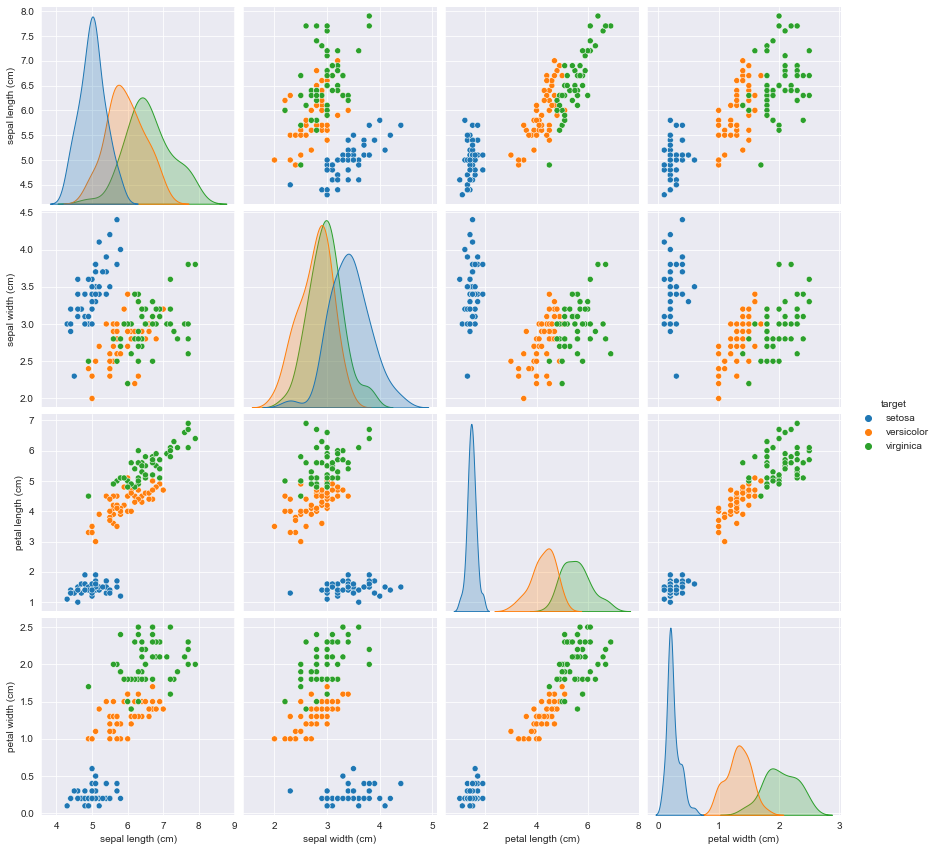

In [4]:
sns.pairplot(iris_df, hue='target', height=3, diag_kind="kde")
plt.show()

In [5]:
from sklearn.preprocessing import StandardScaler

iris_df_norm = pd.DataFrame(data=StandardScaler().fit_transform(iris_df.drop('target', axis=1)), columns=iris.feature_names)
iris_df_norm['target'] = iris_df['target']
iris_df_norm

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,-0.900681,1.019004,-1.340227,-1.315444,setosa
1,-1.143017,-0.131979,-1.340227,-1.315444,setosa
2,-1.385353,0.328414,-1.397064,-1.315444,setosa
3,-1.506521,0.098217,-1.283389,-1.315444,setosa
4,-1.021849,1.249201,-1.340227,-1.315444,setosa
...,...,...,...,...,...
145,1.038005,-0.131979,0.819596,1.448832,virginica
146,0.553333,-1.282963,0.705921,0.922303,virginica
147,0.795669,-0.131979,0.819596,1.053935,virginica
148,0.432165,0.788808,0.933271,1.448832,virginica


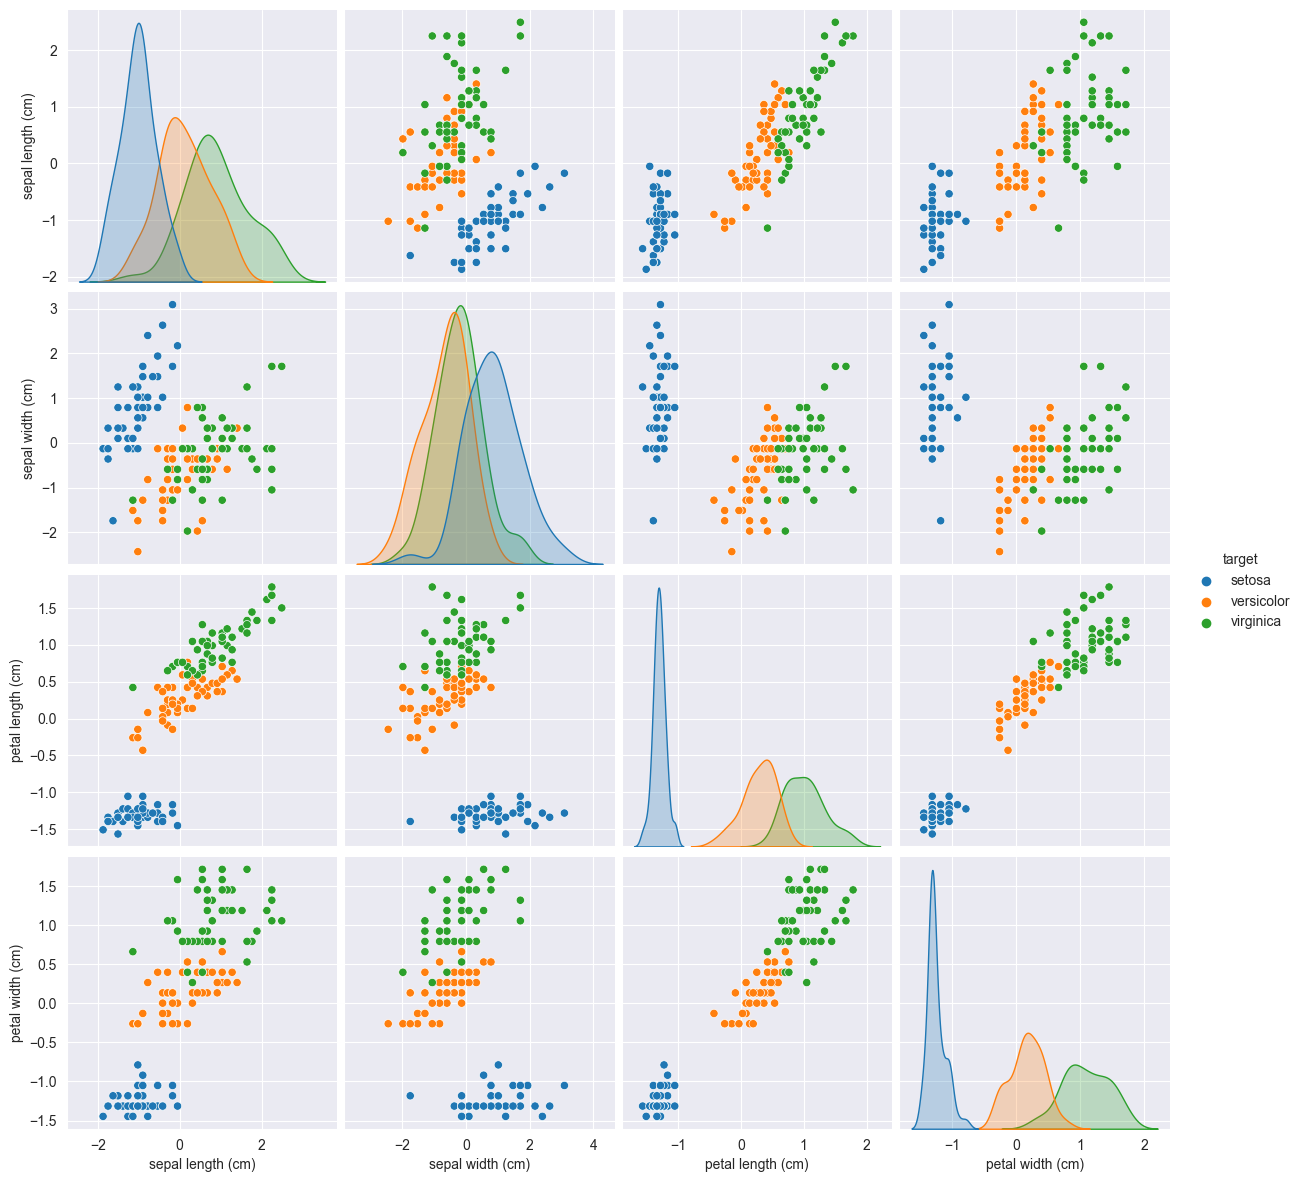

In [6]:
sns.pairplot(iris_df_norm, hue='target', height=3, diag_kind="kde")
plt.show()

In [7]:
iris_df = iris_df.drop('target', axis=1)
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [11]:
from sklearn.base import BaseEstimator


class KNNClassifier(BaseEstimator):
    def __init__(self, k_neighbors = 5):
        self.k_neighbors = k_neighbors
    
    def __to_numpy(self, d):
        if isinstance(d, pd.DataFrame) or isinstance(d, pd.Series):
            return d.to_numpy()
        if isinstance(d, list):
            return np.array(d)
        
        return d
    
    def fit(self, X, y):
        self.X, self.y = self.__to_numpy(X), self.__to_numpy(y)
        self.classes = np.sort(np.unique(y))
        
        return self
    
    def predict_proba(self, X):
        points = self.__to_numpy(X)
        results = []
        for p in points:
            probs = []
            neighbors = self.y[np.sum((self.X - p)**2, axis=1).argsort()[:self.k_neighbors]]
            for c in self.classes:
                probs.append((neighbors == c).sum() / self.k_neighbors)
            results.append(probs)
        
        return np.array(results)
    
    def predict(self, X):
        probs = self.predict_proba(X)
        return probs.argmax(axis=1)

In [12]:
np.sqrt(len(iris_df))

12.24744871391589

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('std', StandardScaler()),
    ('knn', KNNClassifier())
])

param_grid = {
    "knn__k_neighbors": np.arange(1, 24, 1)
}

grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, scoring="accuracy", error_score='raise', verbose=True)
grid

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('std', StandardScaler()),
                                       ('knn', KNNClassifier())]),
             n_jobs=-1,
             param_grid={'knn__k_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23])},
             scoring='accuracy', verbose=True)

In [22]:
grid.fit(iris_df, target)
print(grid.best_score_)
grid.best_params_

Fitting 5 folds for each of 23 candidates, totalling 115 fits
0.9066666666666666


{'knn__k_neighbors': 1}

In [34]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(iris_df, target, shuffle=True)
knn = KNNClassifier(k_neighbors=1)
knn.fit(X_train, y_train)

accuracy_score(y_test, knn.predict(X_test))

0.9473684210526315

In [37]:
X_test['pred_target'] = list(map(lambda x: iris.target_names[x], knn.predict(X_test)))
X_test['real_target'] = list(map(lambda x: iris.target_names[x], y_test))

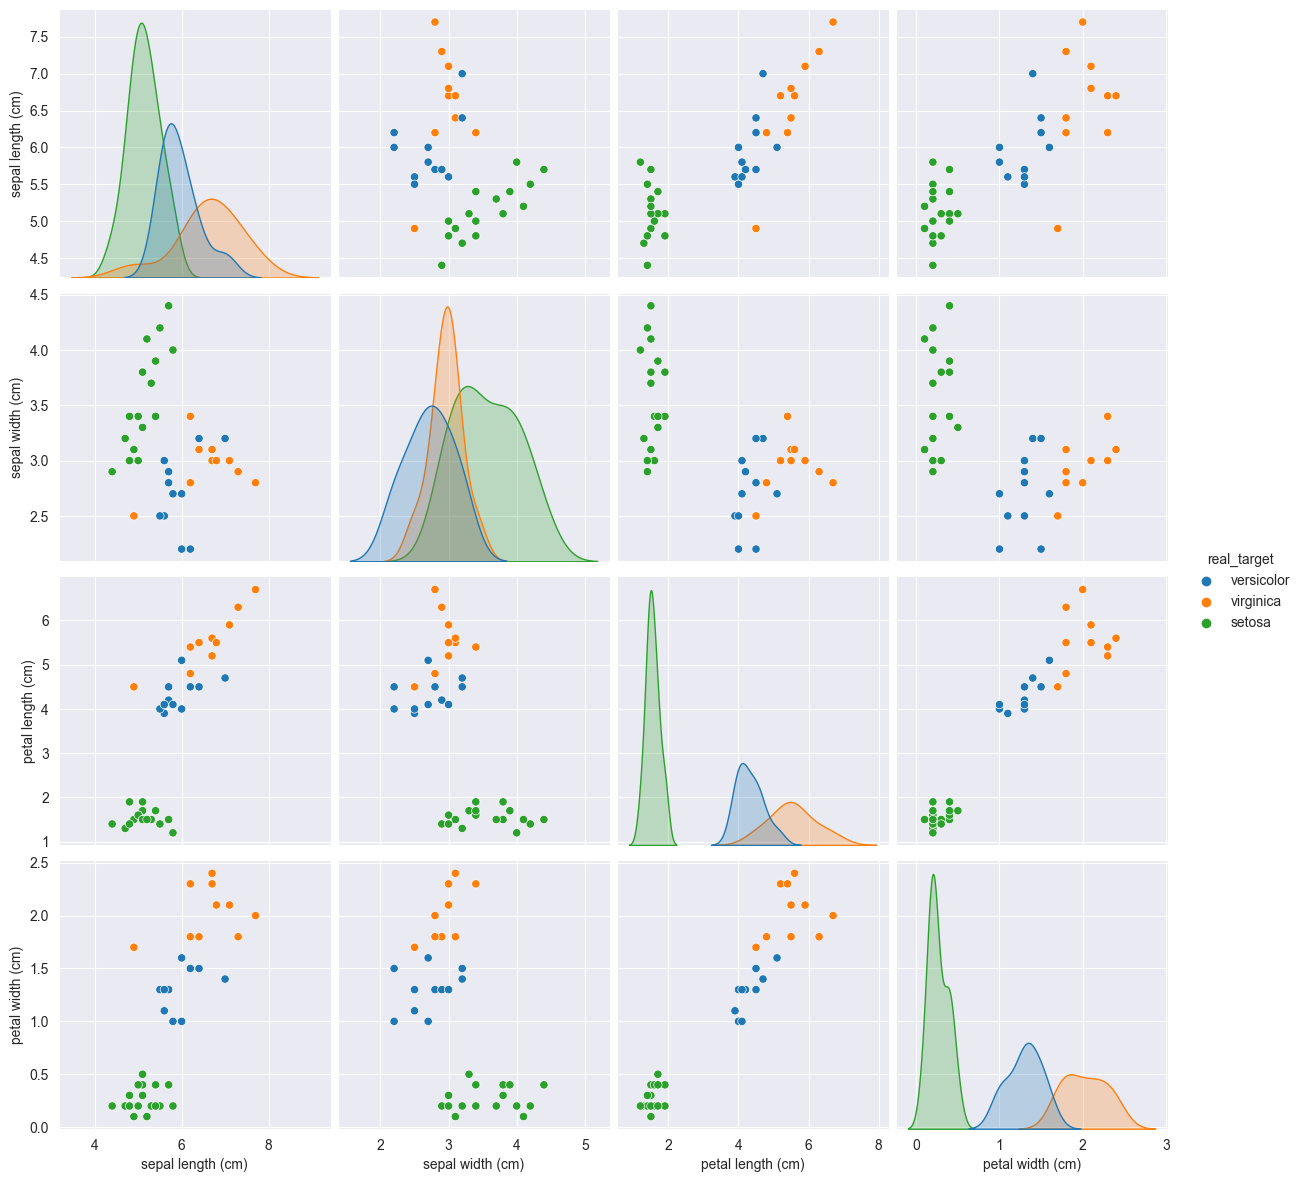

In [41]:
sns.pairplot(X_test, hue='real_target', height=3, diag_kind="kde", hue_order=['versicolor', 'virginica', 'setosa'])
plt.show()

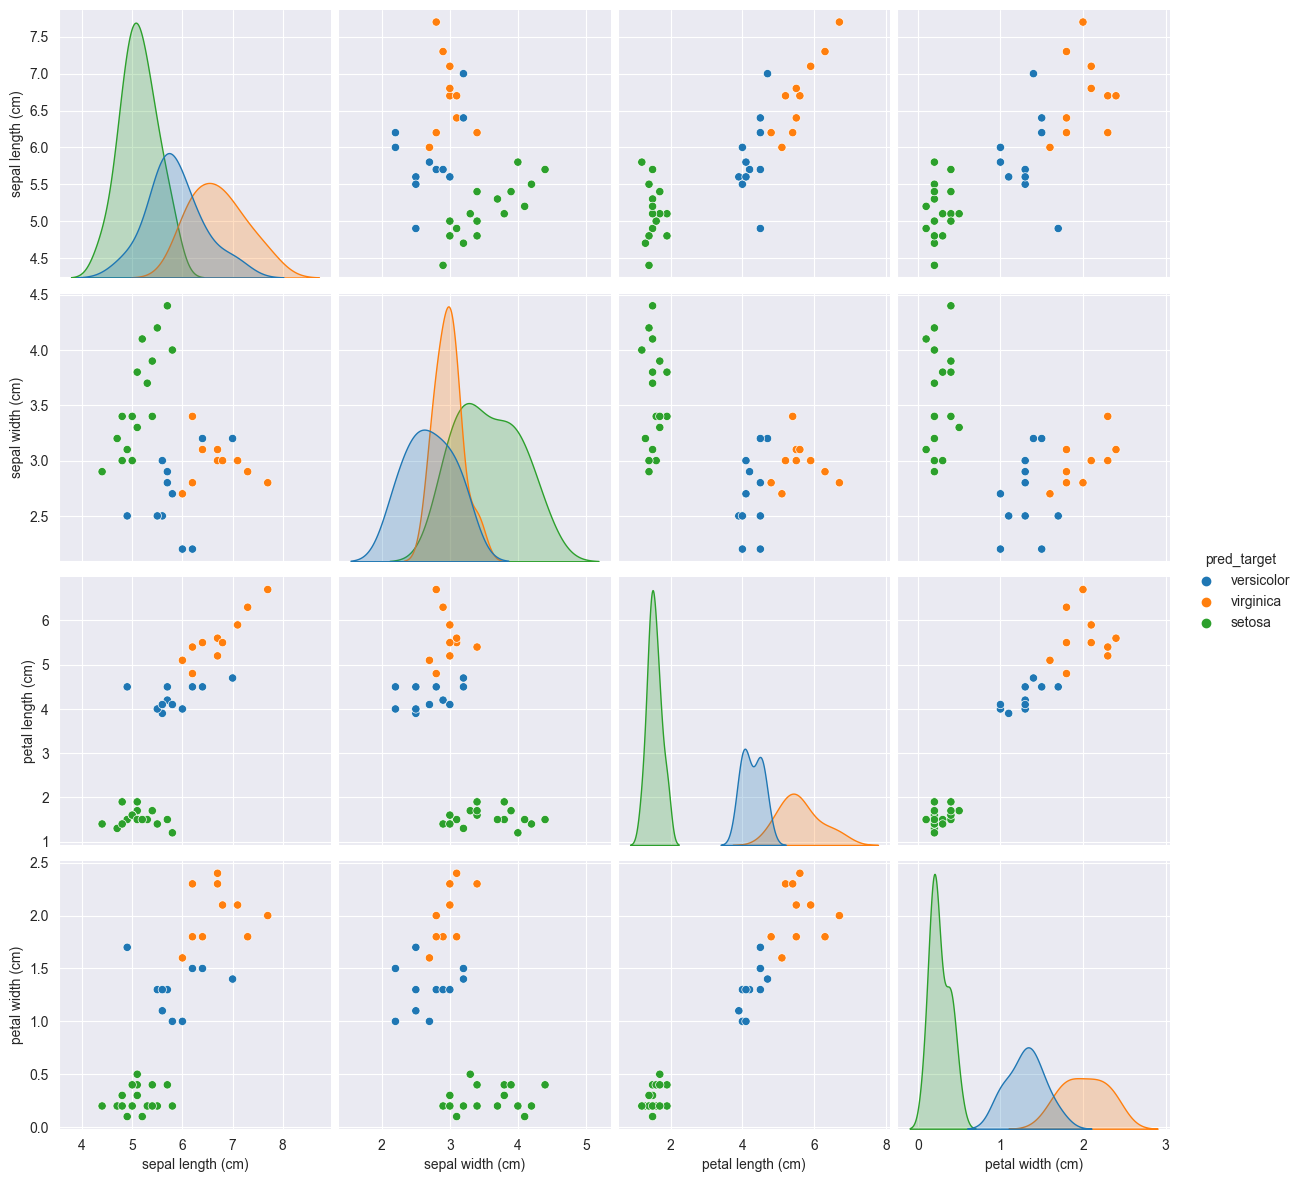

In [42]:
sns.pairplot(X_test, hue='pred_target', height=3, diag_kind="kde", hue_order=['versicolor', 'virginica', 'setosa'])
plt.show()